In [2]:
cd ../../../Downloads/xBenedetta/

/home/benny/Downloads/xBenedetta


In [1]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [3]:
def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window
    Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window
    """
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],window=window,FUN=FUN)                       
        return output
    output = np.zeros(x.size)
    for samp_i in range(x.size):
        values = []
        # loop through the window:
        for wind_i in range(int(1 - window), 1):
            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue
            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]
        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)
    return output


In [4]:
def findmaxima(_input):
    maxima=[]
    for i in range(1, len(_input)-1):
        if (_input[i-1] < _input[i] and _input[i] > _input[i+1]): 
                maxima.append([i, _input[i]])
    maxima = np.array(maxima)
    return(maxima)

# Dataset 1 

In [5]:
import mat73
#mat = mat73.loadmat("StimPiezo_002_210211_114350.mat");
mat = mat73.loadmat("StimPiezo_002_210211_114350.mat")
#103822

/home/benny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
#import mat73
#mat = mat73.loadmat("StimPiezo_210119_123701.mat");

In [6]:
matr = mat['amplifier_data']

In [7]:
stim = mat['adc_data']
stim2 = mat['dig_in_data']

In [8]:
from scipy import signal
import numpy as np
t = np.arange(0,len(matr[0]))*0.00004
dt = t[1]-t[0]
fs = 1/dt
nyq = 0.5*fs
lowcut = 6 - 1 # verificare questa frequenza dominante
highcut = 6 + 1
low = lowcut / nyq
high = highcut / nyq
order = 2
f, h = signal.butter(order, [low,high], btype='bandpass')

lowcut = 0.1
highcut = 150
low = lowcut / nyq
high = highcut / nyq
order = 2
f2, h2 = signal.butter(order,[low, high], btype='bandpass')
newdata = np.empty((27,len(matr[0])))
lfp = np.empty((27,len(matr[0])))

for s in range(27):
    sig = matr[s,:]
    lfp[s,:] = signal.filtfilt(f2, h2, sig, padlen=150)    
    newdata[s,:] = signal.filtfilt(f, h, sig, padlen=150)

In [9]:
def Thres(coef,x):
    """
    Calculates Quiroga detection threshold
    """
    return coef*np.median(np.abs(x)/0.6745) 

def findpeaks(sig, thres, choose):
    """
    Finds peaks in a time series.
    Set eventual other constraints in the scipy.signal function find_peaks
    """
    sig2 = np.zeros(sig.shape, dtype = int)
    if choose == "neg":
        p1 = find_peaks(-(sig - np.mean(sig)), height = thres, distance = 10)[0]
        if np.any(p1):
            sig2[p1] = 1
            
    if choose == "posneg":
        p1 = find_peaks(-(sig - np.mean(sig)), height = thres)[0]
        p2 = find_peaks((sig - np.mean(sig)), height = thres)[0]
        if np.any(p1.tolist() + p2.tolist()):
            sig2[np.array(p1.tolist()+ p2.tolist())] = 1
    return sig2

def firingrate(array, timebin=250):
    # array shape: trials x time x channels
    
    time = array.shape[1]
    rest = int(timebin)*int(time/timebin + 1) - int(time) 

    firingrates = np.zeros((array.shape[0],int((time + rest)/timebin), timebin))
    array = np.sum(array,2)

    for l in range(len(array)):
        firingrates[l] =np.append(array[l,:], np.zeros(rest)).reshape(int((time+rest)/timebin), timebin)

    firingrates = np.sum(firingrates, axis = 2)
    return firingrates

In [10]:
def RasterPlot(spikes,ax):
    #print(spikes.shape)
    idx = spikes > 0
    #print(idx)
    #print(idx.shape)
    times = np.arange(0,len(spikes),1)
    #print(times.shape)
    for l in range(spikes.shape[1]):
        x = times[idx[:,l]]
        ax.scatter(x, [l for i in range(len(x))], marker ='s', c = 'black',s = 1.)

In [11]:
import matplotlib.pyplot as plt

In [13]:
from scipy import signal
import numpy as np
t = np.arange(0,len(matr[0]))*0.00004
dt = t[1]-t[0]
fs = 1/dt
nyq = 0.5*fs

lowcut = 300
highcut = 3000
low = lowcut / nyq
high = highcut / nyq
order = 2
f, h = signal.butter(order,high, btype='lowpass')
f2, h2 = signal.butter(order,low, btype='highpass')

spikes = np.empty((27,len(matr[0])))
#lfp = np.empty((27,len(matr[0])))

for s in range(27):
    sig = matr[s,:]
    #lfp[s,:] = signal.filtfilt(f2, h2, sig, padlen=150)    
    sig2 = signal.filtfilt(f, h, sig, padlen=150)
    spikes[s,:] = signal.filtfilt(f2, h2, sig2, padlen=150)    

In [9]:
indexes = (np.where(stim> 1.5)[0])[np.where(np.diff(np.where(stim> 1.5)[0])>1)]
indexes

array([ 214658,  464656,  714654,  964652, 1214650, 1464648, 1714647,
       1964645, 2214643, 2464641, 2714639, 2964638, 3214636, 3464634,
       3714632, 3964630, 4214629, 4464627, 4714625, 4964623, 5214621,
       5464619, 5714618, 5964616, 6214614, 6464612, 6714610, 6964609,
       7214607])

In [14]:
lfp.shape

(27, 7500288)

In [19]:
plt.plot(lfp[])

124

In [24]:
indexes = np.array(indexes.tolist() + [int(indexes[-1] + np.diff(indexes)[-1])]) - 125

NameError: name 'indexes' is not defined

In [38]:
(len(spikes[0]) -  indexes[-1])/25000

1.42732

In [71]:
124/25

4.96

(214000.0, 215000.0)

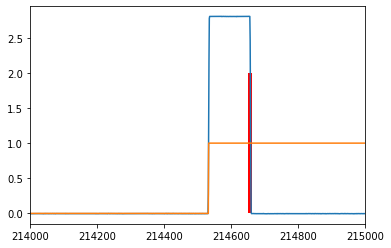

In [19]:
plt.vlines(indexes,0,2, 'r', lw = 4)
plt.plot(stim)
plt.plot(stim2)
plt.xlim(214000,215000)

In [28]:
num = len(indexes)
spikesTrials = np.zeros((num, 25000, 27))
for l in range(len(indexes)):
    spikesTrials[l] = spikes[:,indexes[l]:indexes[l]+25000].T

In [10]:
num = len(indexes)
lfpTrials = np.zeros((num, 25000*9, 27))
for l in range(len(indexes)-1):
    lfpTrials[l] = lfp[:,indexes[l]:indexes[l]+25000*9].T

In [30]:
num = len(indexes)
newdataTrials = np.zeros((num, 25000*9, 27))
for l in range(len(indexes)-1):
    newdataTrials[l] = newdata[:,indexes[l]:indexes[l]+25000*9].T

In [31]:
binspikes =  np.zeros((num,int(25000),27))
for i in range(num):
    #array3Stim[g,i] = newdata[:,int(lis[i]):int(lis[i])+int(25000*2)].transpose()
    #array3StimSpikes[g,i] = newdataspikes[:,int(lis[i]):int(lis[i])+int(25000*2)].transpose()
    for ch in range(27):
        binspikes[i,:,ch] = findpeaks(spikesTrials[i,:,ch], Thres(3.5,spikesTrials[i,:,ch]),"neg")

(0.2, 0.5)

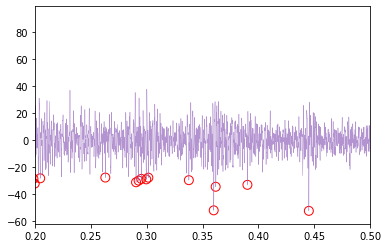

In [43]:
conv = 0.00004
maxtime= 25000
electr = 15
ntrial = 13
time = np.arange(0,maxtime,1)
plt.plot(time*conv,spikesTrials[ntrial,:maxtime,electr], color = "tab:purple",alpha = 0.7,lw =0.5)
plt.scatter((time*conv)[binspikes[ntrial,:maxtime,electr]>0], spikesTrials[ntrial,:maxtime,electr][binspikes[ntrial,:maxtime,electr]>0], s = 80,facecolors='none', edgecolors='r')
plt.xlim(0.2,0.5)

In [44]:
mean= lfpTrials.mean(0)

(0.0, 20.0)

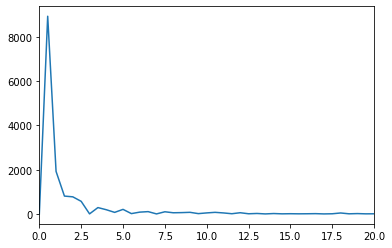

In [45]:
x,Pxx =signal.periodogram(mean[int(25000):int(25000*3),18], fs = 1/0.00004)
plt.plot(x,Pxx)
plt.xlim(0,20)

In [ ]:
pxx =[]
for l in range(29):
    for s in range(27):
        x,Pxx =signal.periodogram(lfpTrials[l,int(25000):int(25000*6),s], fs = 1/0.00004)
        pxx.append(Pxx)
        maxvalues = findmaxima(Pxx)[:,1]
        maxx = np.array(x)[np.array(findmaxima(Pxx)[:,0], dtype = int)][np.argsort(np.array(findmaxima(Pxx)[:,1]))[::-1]]
        #print(maxx[0], maxx[1], maxx[2], maxx[3])

In [77]:
len(indexes)

30

In [79]:
pxx.shape

(783, 62501)

(0.0, 20.0)

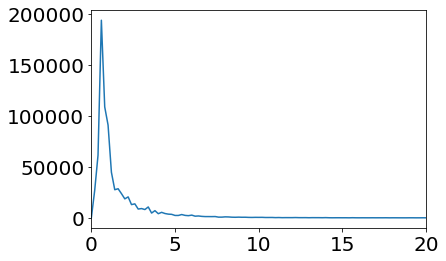

In [78]:
pxx = np.array(pxx)
plt.plot(x,np.mean(pxx,0))
plt.xlim(0,20)

In [81]:
maxvalues = findmaxima(Pxx)[:,1]
maxx = np.array(x)[np.array(findmaxima(Pxx)[:,0], dtype = int)][np.argsort(np.array(findmaxima(Pxx)[:,1]))[::-1]]
maxx[0], maxx[1], maxx[2], maxx[3]

(0.8, 0.4, 1.4000000000000001, 4.4)

NameError: name 'maxx' is not defined

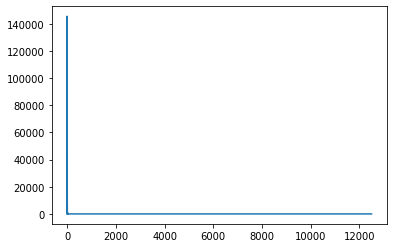

In [38]:
#x,Pxx =signal.periodogram(mean[:int(25000*0.5),18], fs = 1/0.00004)
pxx = np.array(pxx)
plt.plot(x,np.mean(pxx,0))
plt.plot(maxx[0], maxvalues[0], 'ro')
plt.xlim(0,20)

In [39]:
Pxx = np.mean(pxx,0)
maxvalues = findmaxima(Pxx)[:,1]
maxx = np.array(x)[np.array(findmaxima(Pxx)[:,0], dtype = int)][np.argsort(np.array(findmaxima(Pxx)[:,1]))[::-1]]

In [40]:
maxx[0]

0.8

(0.0, 20.0)

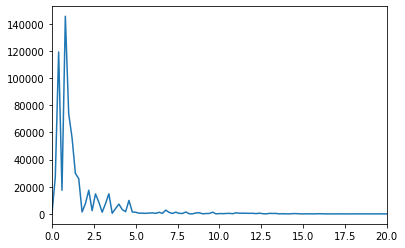

In [41]:
#x,Pxx =signal.periodogram(mean[:int(25000*0.5),18], fs = 1/0.00004)
pxx = np.array(pxx)
plt.plot(x,np.mean(pxx,0))
plt.xlim(0,20)

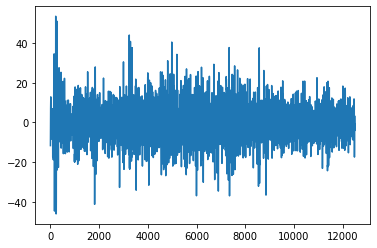

In [42]:
##### lfpTrials.shape
plt.plot(spikesTrials[10,:int(25000*0.5),15])

In [29]:
trial = binspikes[:10].sum(0)
trial = np.array(trial > 0, dtype = int)

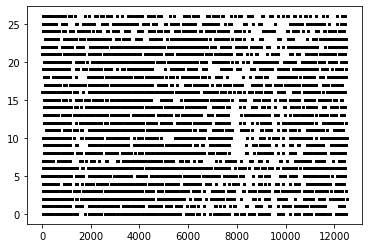

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
RasterPlot(trial[:int(25000*0.5)],ax)

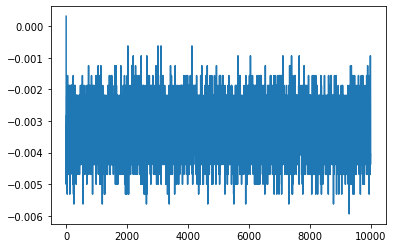

In [44]:
plt.plot(stim[:10000])

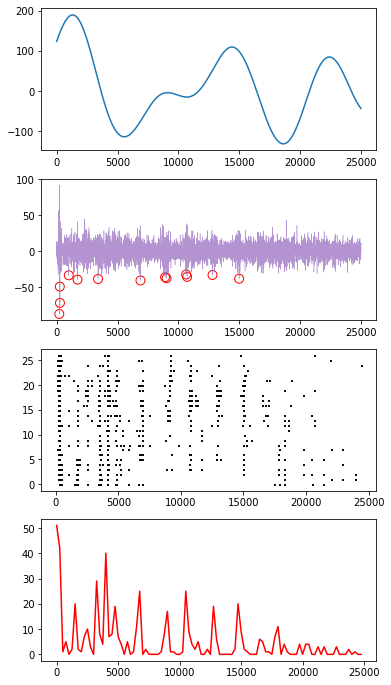

In [48]:
timebin = 250
electr = 15
#trial = 9 StimPiezo_001_210122_102100.m
trial =28
time =int(25000)

fir = firingrate(binspikes, timebin)

fig = plt.figure(figsize = (6,12))


ax = fig.add_subplot(4,1,1)
ax.plot(newdataTrials[trial,:int(time),electr])


conv = 0.00004
#maxtime= 25000

#ntrial = 10

ax = fig.add_subplot(4,1,2)

times = np.arange(0,time,1)
ax.plot(times,spikesTrials[trial,:time,electr], color = "tab:purple",alpha = 0.7,lw =0.5)
ax.scatter((times)[binspikes[trial,:time,electr]>0], spikesTrials[trial,:time,electr][binspikes[trial,:time,electr]>0], s = 80,facecolors='none', edgecolors='r')

ax = fig.add_subplot(4,1,3)
RasterPlot(binspikes[trial,:int(time)],ax)

ax = fig.add_subplot(4,1,4)
ax.plot(np.arange(0,int(time/timebin)*timebin,timebin), fir[trial,:int(time/timebin)], 'r');




In [26]:
30000/25

1200.0

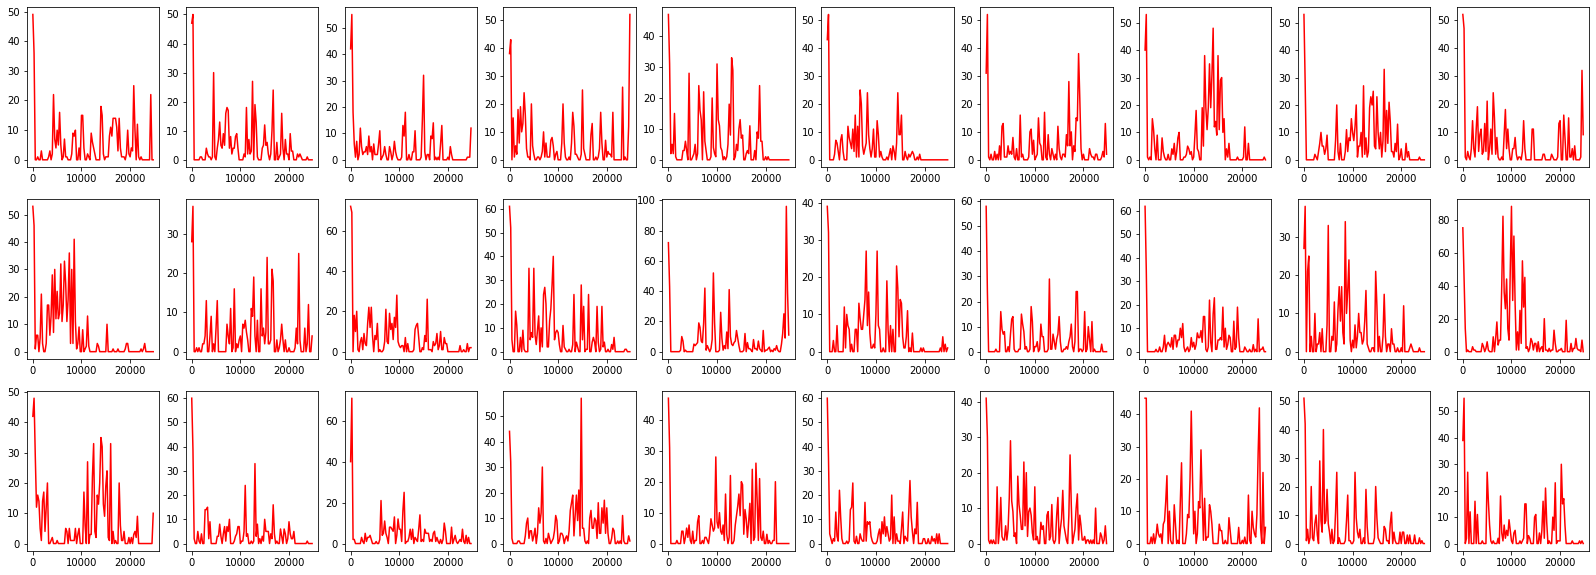

In [49]:
timebin = 250
#electr = 10
#trial = 9
fig, ax = plt.subplots(3,10, figsize = (28,10))
time =25000
num = lfpTrials.shape[0]
fir = firingrate(binspikes, timebin)

for l in range(10):


    conv = 0.00004
    #maxtime= 25000

    ax[0,l].plot(np.arange(0,int(time/timebin)*timebin,timebin), fir[l,:int(time/timebin)], 'r');
    ax[1,l].plot(np.arange(0,int(time/timebin)*timebin,timebin), fir[l+ 10,:int(time/timebin)], 'r');
    #if l <9:
    ax[2,l].plot(np.arange(0,int(time/timebin)*timebin,timebin), fir[l+ 20,:int(time/timebin)], 'r');
    


In [67]:
fir = firingratesingle(binspikes,250)

In [73]:
np.mean(fir,0).shape

(901, 27)

(0.0, 100.0)

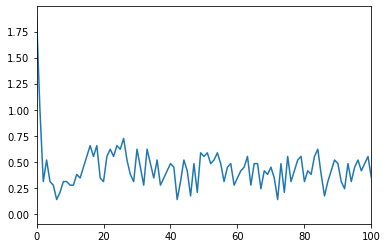

In [68]:
plt.plot(np.mean(fir,0)[:,22])
plt.xlim(0,int(25000/250))

In [14]:

def firingratesingle(array, timebin=250):
    # array shape: trials x time x channels
    
    time = array.shape[1]
    rest = int(timebin)*int(time/timebin + 1) - int(time) 

    firingrates = np.zeros((array.shape[0],int((time + rest)/timebin), timebin,27))
    #array = np.sum(array,2)

    for l in range(len(array)):
        for el in range(27):
            firingrates[l,:,:,el] =np.append(array[l,:,el], np.zeros(rest)).reshape(int((time+rest)/timebin), timebin)

    firingrates = np.sum(firingrates, axis = 2)
    return firingrates

In [41]:
binspikes.shape

(29, 225000, 27)

In [20]:
import matplotlib.cm as cm
maxtime = 25000*1
trialstim1 = binspikes[28].T[:,:maxtime]
timebin = 100
time = trialstim1.shape[1]
rest =  int(timebin)*int(time/timebin + 1) - int(time) 

rebinned = np.zeros((trialstim1.shape[0],int((time + rest)/timebin), timebin))
print(rebinned.shape,rest, trialstim1.shape)
for l in range(len(trialstim1)):
    rebinned[l] =np.append(trialstim1[l,:], np.zeros(rest)).reshape(int((time+rest)/timebin), timebin)
print(rebinned.shape)
rebinned = np.sum(rebinned, axis = 2)
print(rebinned.shape)


plt.figure()
    #t = np.arange(0,array.shape[1],1)
plt.imshow(rebinned,                                   # Image the data from condition A.
           cmap=cm.jet,                            # ... set the colormap (optional)
           extent=[0*timebin*conv, rebinned.shape[1]*timebin*conv, 1, rebinned.shape[0]],       # ... set axis limits (t[-1] represents the last element of t)
           aspect='auto',                          # ... set aspect ratio 
           origin='lower')                         # ... put origin in lower left corner
plt.xlabel('Time[s]')                              # Label the axes
plt.ylabel('Channel #')
plt.colorbar();  

NameError: name 'binspikes' is not defined

(27, 163, 150) 75 (27, 24375)
(27, 163, 150)
(27, 163)


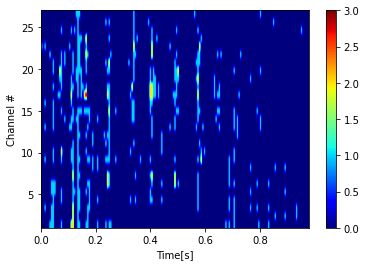

In [52]:
import matplotlib.cm as cm
maxtime = 25000
trial = 28
trialstim1 = binspikes[trial].T[:,625:maxtime]
timebin = 150
time = trialstim1.shape[1]
rest =  int(timebin)*int(time/timebin + 1) - int(time) 

rebinned = np.zeros((trialstim1.shape[0],int((time + rest)/timebin), timebin))
print(rebinned.shape,rest, trialstim1.shape)
for l in range(len(trialstim1)):
    rebinned[l] =np.append(trialstim1[l,:], np.zeros(rest)).reshape(int((time+rest)/timebin), timebin)
print(rebinned.shape)
rebinned = np.sum(rebinned, axis = 2)
print(rebinned.shape)


plt.figure()
    #t = np.arange(0,array.shape[1],1)
plt.imshow(rebinned,                                   # Image the data from condition A.
           cmap=cm.jet,                            # ... set the colormap (optional)
           extent=[0*timebin*conv, rebinned.shape[1]*timebin*conv, 1, rebinned.shape[0]],       # ... set axis limits (t[-1] represents the last element of t)
           aspect='auto',                          # ... set aspect ratio 
           origin='lower')                         # ... put origin in lower left corner
plt.xlabel('Time[s]')                              # Label the axes
plt.ylabel('Channel #')
plt.colorbar();  

In [126]:
rebinned.shape[1]

98

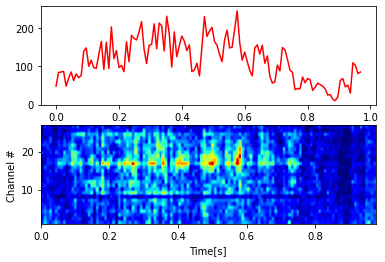

In [53]:
import matplotlib.cm as cm
maxtime = 25000
trialstim1 = np.sum(binspikes,0).T[:,625:maxtime]
timebin = 200
time = trialstim1.shape[1]
rest =  int(timebin)*int(time/timebin + 1) - int(time) 

rebinned = np.zeros((trialstim1.shape[0],int((time + rest)/timebin), timebin))
#(rebinned.shape,rest, trialstim1.shape)
for l in range(len(trialstim1)):
    rebinned[l] =np.append(trialstim1[l,:], np.zeros(rest)).reshape(int((time+rest)/timebin), timebin)
#print(rebinned.shape)
rebinned = np.sum(rebinned, axis = 2)
#print(rebinned.shape)
#ax.set_xlim(0,rebinned.shape[1]*timebin*conv)# ... put origin in lower left corner


fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(np.arange(0, rebinned.shape[1],1)*timebin*conv,np.sum(rebinned,0), 'r')
ax = fig.add_subplot(2,1,2)
    #t = np.arange(0,array.shape[1],1)
ax.imshow(rebinned,                                   # Image the data from condition A.
           cmap=cm.jet,                            # ... set the colormap (optional)
           extent=[0*timebin*conv, rebinned.shape[1]*timebin*conv, 1, rebinned.shape[0]],       # ... set axis limits (t[-1] represents the last element of t)
           aspect='auto',                          # ... set aspect ratio 
           origin='lower') 
ax.set_xlim(0,rebinned.shape[1]*timebin*conv)# ... put origin in lower left corner
ax.set_xlabel('Time[s]')                              # Label the axes
ax.set_ylabel('Channel #');
#plt.colorbar();  

                                   # Show voltage to color mapping
#plt.vlines(0.25, 1, 1000, 'k', lw=2)
            # Indicate stimulus onset with line
#plt.savefig('Figs/summedactivity' + '6-19' +'.pdf')
#plt.show()

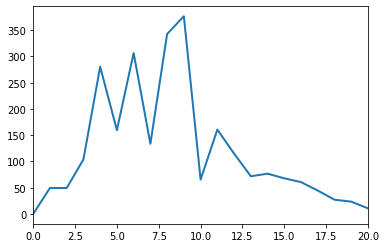

In [47]:
el = 11
sig = lfpTrials.mean(0)[:25000,el]
x, Pxx = signal.periodogram(sig, fs = 1/0.00004)
plt.plot(x,Pxx, lw = 2)
plt.xlim(0,20);

In [20]:
del lfp

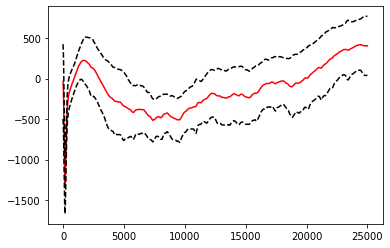

In [22]:
el = 10
plt.plot(lfpTrials.mean(0)[:25000,el],'r')
plt.plot(lfpTrials.mean(0)[:25000,el] + lfpTrials.std(0)[:25000,el] ,'k--')
plt.plot(lfpTrials.mean(0)[:25000,el] - lfpTrials.std(0)[:25000,el],'k--');

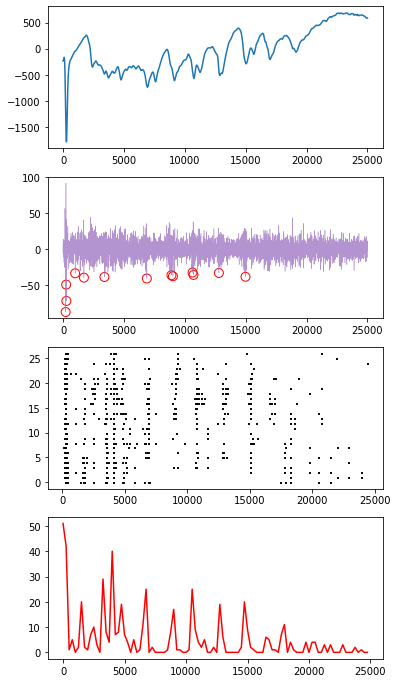

In [56]:
timebin = 250
electr = 15
trial = 28

time =25000

fir = firingrate(binspikes, timebin)

fig = plt.figure(figsize = (6,12))


ax = fig.add_subplot(4,1,1)
ax.plot(lfpTrials[trial,:int(time),electr])


conv = 0.00004
#maxtime= 25000

#ntrial = 10

ax = fig.add_subplot(4,1,2)

times = np.arange(0,time,1)
ax.plot(times,spikesTrials[trial,:time,electr], color = "tab:purple",alpha = 0.7,lw =0.5)
ax.scatter((times)[binspikes[trial,:time,electr]>0], spikesTrials[trial,:time,electr][binspikes[trial,:time,electr]>0], s = 80,facecolors='none', edgecolors='r')

ax = fig.add_subplot(4,1,3)
RasterPlot(binspikes[trial,:int(time)],ax)

ax = fig.add_subplot(4,1,4)
ax.plot(np.arange(0,time,timebin), fir[trial,:int(time/timebin)], 'r');




In [117]:
len(np.arange(0,time,timebin)),len(fir[0])

(2000, 4501)

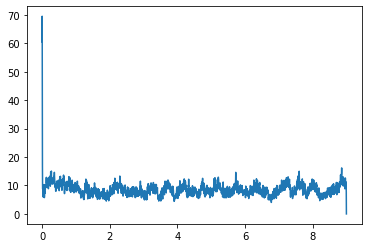

In [140]:
plt.plot(np.arange(0,len(spikesTrials[0]) + 1,timebin)*conv,np.mean(fir[:],0))
#plt.xlim(0.,4)

(0.0, 500000.0)

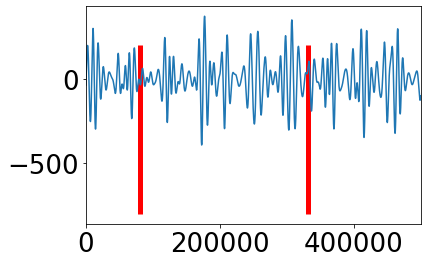

In [93]:
plt.vlines(indexes,-800,200, 'r', lw =5)
plt.plot(newdata[13,:25000*20])
plt.xlim(0,25000*20)

In [74]:
x,Pxx = signal.periodogram(newdata[18,indexes[0]:indexes[0]+ int(25000*0.5)],fs = 1/0.00004)

(0.0, 7.5)

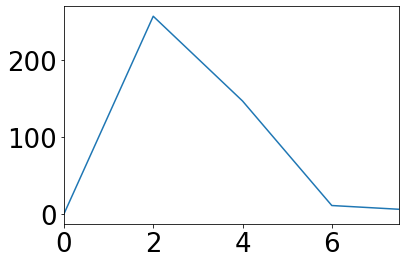

In [75]:
plt.plot(x,Pxx)
plt.xlim(0,7.5)

In [14]:
indexes = (np.where(stim> 1.5)[0])[np.where(np.diff(np.where(stim> 1.5)[0])>1)]
indexes

array([  81450,  331449,  581448,  831447, 1081445, 1331444, 1581443,
       1831442, 2081441, 2331440, 2581439, 2831438, 3081437, 3331436,
       3581435, 3831434, 4081433, 4331432, 4581431, 4831430, 5081429,
       5331428, 5581427, 5831425, 6081424, 6331423, 6581422, 6831421,
       7081420])

In [11]:
def R_helper_detector_LFP(_input):
    maxima=[]
    for i in range(1, len(_input)-1):
        if (_input[i-1] < _input[i] and _input[i] > _input[i+1]) and _input[i] > np.median(_input) : 
                maxima.append([i, _input[i]])
    maxima = np.array(maxima)
    return(maxima)

In [28]:
t_s = 25000*7
trials = []
for r in range(1,len(indexes)-1):
    for el in range(27):
        trials.append(newdata[el,indexes[r]-t_s:indexes[r]+25000*3])

In [12]:
t_s = int(25000*2)
trials = []
for r in range(1,len(indexes)-1):
    for el in range(27):
        trials.append(newdata[el,indexes[r]-t_s:indexes[r]+int(25000*2)])
trials = np.array(trials)

## Phase response curve

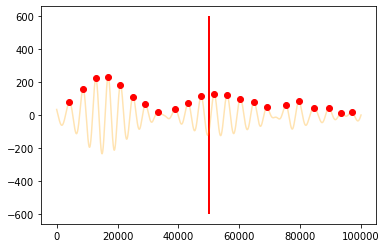

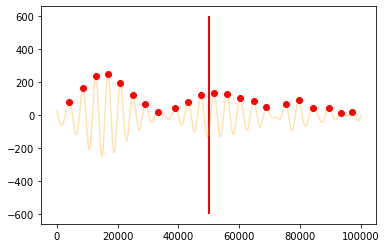

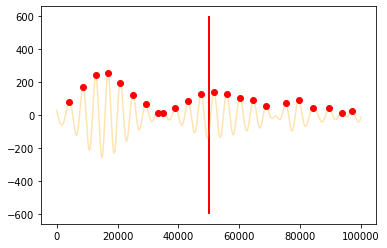

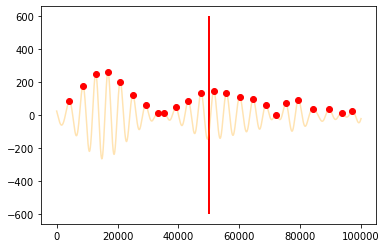

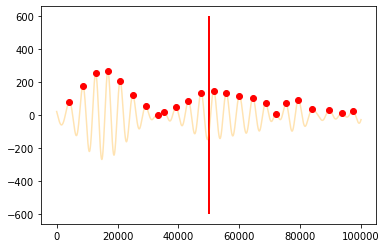

In [13]:
phasestim = []
phases = []
#t_s = 25000*6 # automatizzare questa cosa
#t_s = 3051
o = 0

for trial in range(1,trials.shape[0]):
    peaks =R_helper_detector_LFP(trials[trial,:])
    if trial < 6:
        plt.figure()
        plt.plot(trials[trial], 'orange', alpha = 0.3)

        plt.plot(peaks[:,0],peaks[:,1], 'ro')
        plt.vlines(t_s,-600,600, 'r', lw = 2)
        #plt.xlim(1000,1500)


    idx = np.where( (t_s- peaks[:,0]) == (t_s- peaks[:,0])[(t_s- peaks[:,0])>0].min())[0][0]
    time = peaks[:,0][idx]
    ts = t_s - time
    #t_s = 1110
    T0 =[]
    for r in range(len(peaks[:idx])):
        #print(len(peaks[:idx-1]))
        T0.append(peaks[:,0][idx-r] - peaks[:,0][idx -1-r])

    T0 = np.array(T0).mean()
    T1 = peaks[:,0][idx + 1] - peaks[:,0][idx]
    phase = (T0 - T1)/T0*2*np.pi
    phase_stim = ts/T0*2*np.pi
    if phase_stim > 2*np.pi: o+= 1
    f1 = np.sign(phase_stim)*(np.abs(phase_stim))%(2*np.pi)
    #print(phase_stim)
    #print(np.angle(np.exp(1j*phase_stim)) + np.pi, np.sign(phase_stim)*(np.abs(phase_stim))%(2*np.pi))
    phasestim.append(f1)
    #f2 = np.sign(phase)*(np.abs(phase))
    phases.append(np.angle(np.exp(1j*phase)))
    """
    if f2 > np.pi:
        phases.append(f2 - 2*np.pi)
    elif f2 < -np.pi:
        phases.append(f2 + 2*np.pi)
    else:
        phases.append(f2)
    """

In [14]:
1/(T0*0.00004)

6.108396268325189

In [48]:
trials.shape

(729, 250000)

(45000.0, 55000.0)

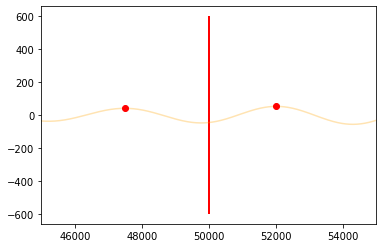

In [15]:
plt.figure()
trial = 728
plt.plot(trials[trial], 'orange', alpha = 0.3)

plt.plot(peaks[:,0],peaks[:,1], 'ro')
plt.vlines(t_s,-600,600, 'r', lw = 2)
plt.xlim(t_s-5000, t_s+5000)
## check mi prenda i periodi giusti

In [65]:
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

In [16]:
phases = np.array(phases)
phasestim = np.array(phasestim)
phases = phases[np.argsort(phasestim)]
phasestim = np.sort(phasestim)

for g in range(len(phasestim)):
    phasestim[g] = round(phasestim[g],3)
uni = np.unique(phasestim)
uniphases = [[] for r in range(len(uni))]
for l in range(len(uni)):
    for r in range(len(phases)):
        if phasestim[r] == uni[l]:
            uniphases[l].append(phases[r])

In [17]:
means = []
stds =[]
for r in range(len(uniphases)):
    means.append(np.mean(uniphases[r]))
    stds.append(np.std(uniphases[r])/np.sqrt(len(uniphases[r])))    

In [18]:
means,stds = np.array(means), np.array(stds)
#uniphases = np.array(uniphases)

In [19]:
mean = my_moving_window(means,10)
std = my_moving_window(stds,10)
unii = my_moving_window(uni,10)

## Fit of Fourier Coefficients

In [20]:
y = np.array(means)
oss01 = np.ones((len(uni)))
oss1 = np.cos(uni)
oss2 = np.cos(2*uni)
#oss02 = np.ones((len(unii)))
oss3 = np.sin(uni)
oss4 = np.sin(2*uni)

X = np.vstack((oss1,oss2,oss3,oss4,oss01)).T
a1,a2,b1,b2,a0= (np.linalg.inv(X.T @ X) @ X.T) @ y

$\beta = (X^T X)^{-1} X^T y$

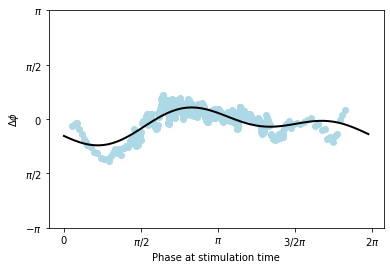

In [21]:
#1/(T0*10**-3), 1/(T1*10**-3)

plt.scatter(unii,mean,c = 'lightblue', marker = 'o')
theta = np.arange(0,2*np.pi,0.1)
plt.plot(theta, a0 + a1*np.cos(theta) + a2*np.cos(2*theta)+  b1*np.sin(theta) + b2*np.sin(2*theta), 'k', lw = 2 )
#plt.plot(theta, a01 + a11*np.cos(theta) + a21*np.cos(2*theta)+  b11*np.sin(theta) + b21*np.sin(2*theta),color = 'orange' )

plt.xticks(np.arange(0,2*np.pi + np.pi/2,np.pi/2), labels = ["0", "$\pi/2$","$\pi$","$3/2\pi$","$2\pi$"])
plt.yticks(np.arange(-np.pi,np.pi + np.pi/2,np.pi/2), labels = ["$-\pi$","$\pi/2$","$0$","$\pi/2$","$\pi$"])
plt.xlabel('Phase at stimulation time')
plt.ylabel(r'$\Delta \phi$');
#plt.savefig('Fig/PRC2s.jpg', dpi = 300, bbox_inches ='tight')